<a href="https://colab.research.google.com/github/lsmanoel/raycasting/blob/master/raycasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raycasting
Uma adaptacão do tutorial [Lode's Computer Graphics Tutorial
Raycasting](https://lodev.org/cgtutor/raycasting.html)

O Raycasting é uma técnica para dar uma perspectiva 3D para mapas inicialmente criados em 2D. Essa técnica possui um custo computacional muito pequeno pois é necessário apenas um cálculo simples para processar cada linha vertical presente na tela.

A ideia básica do Raycasting consiste que o mapa é uma grade de quadrados 2D (unidades de mapa) e cada um desses quadrados pode assumir um valor 0 para onde não há paredes e um valor positivo para representar a parede.

![alt text](https://lodev.org/cgtutor/images/raycastgrid.gif)

Tendo em vista o mapa 2D, para cada pixel contido dentro do campo de visão do observador, há uma linha que liga esse pixel ao ponto onde se localiza o observador. Essas linhas se expandem pelo mapa 2D até atingir um quadrado com valor diferente de zero representando uma parede. Dessa forma a altura da parede é calculada em função do comprimento dessa linha. Essa linha é denominada de **Ray**.

Para que as  Rays possam encontrar as paredes mais próximas á visão do observador, é necessário verificar a colisão das linhas com a parede começando pelos pontos mais próximos ao observador. Quando a colisão ocorre, a distância entre o observador e a parede será proporcional ao número de iterações ocorridas no rastreio da colisão entre as Rays e a parede. 

Existem algumas variedades de forma de representar a direção do observador. Uma forma simples de representar é considerando que a direção, assim como a posição do observador, são pares de coordenadas X e Y. Se for traçada uma Ray na direção no qual o observador estiver olhando, originando da posição do observador, cada ponto da da Ray será a soma do vetor posição com um múltiplo do vetor de direção.

Um terceiro vetor necessário além do vetores de posição e direção é o vetor que define o plano da câmera. Esse vetor é sempre perpendicular ao vetor direção e representa a superfície da tela do computador.

![alt text](https://lodev.org/cgtutor/images/raycastingcamera.gif)

Na imagem acima é possível observar um ponto verde representando a posição do observador. Saindo desse ponto uma linha preta representa o vetor direção. E perpendicular a linha preta uma linha roxa representa o vetor que define o plano da câmera. Quando o observador rotaciona a direção para qual está olhando, todos os vetores rotacionam juntos. Para efetuar a rotação de um vetor basta fazer uma multiplicação vetorial desse com a matriz de rotação:

$$
\left[
\begin{array}{c}
x_{new} \\
y_{new}
\end{array}
\right]
=
\left[
\begin{array}{cc}
\cos(\theta)   & -\sin(\theta)  \\
\sin(\theta)  & \cos(\theta)
\end{array}
\right]
*
\left[
\begin{array}{c}
x \\
y
\end{array}
\right]
$$

![alt text](https://lodev.org/cgtutor/images/raycastingcamerarotate.gif)



# Algorítimo DDA

Como na procura por colisões o computador é limitado a dar passos discretos durante as iterações, passos grandes podem gerar um problema como demonstrado na figura abaixo, onde cada ponto vermelho é a posição ao longo de uma das Rays onde é verificado se há uma colisão.

![alt text](https://lodev.org/cgtutor/images/raycastmiss.gif)

Trabalhar com um passo menor ajudaria a minimizar problema mas demandaria uma carga computacional maior.

![alt text](https://lodev.org/cgtutor/images/raycastmiss2.gif)

A melhor solucão seria utilizar um passo variável onde a verificação é feita nas extremidades de cada unidade quadrada do mapa. O algorítimo [DDA "Digital Differential Analysis"](https://en.wikipedia.org/wiki/Digital_differential_analyzer_(graphics_algorithm)) permite fazer isso.

![alt text](https://lodev.org/cgtutor/images/raycasthit.gif)

Os pontos da Ray são representados por valores de ponto flutuante e podem indicar em qual quadrado a colisão ocorre.
Na figura abaixo, **sideDistX** e **sideDistY** são as distâncias iniciais que as Rays se propagam da posicão do abservador até a primeira lateral de unidade de mapa.  As variáveis **deltaDistX** e **deltaDistY** é a distância entre as demais laterais das unidades do mapa.

![alt text](https://lodev.org/cgtutor/images/raycastdelta.gif)

Essas variáveis são calculadas por meio de uma derivacão geométrica utilizando Pitágoras:

$$deltaDistX = \sqrt{1 + \frac{rayDirY²}{rayDirX²}} = abs(\frac{1}{rayDirX})$$

$$deltaDistY = \sqrt{1 + \frac{rayDirX²}{rayDirY²}} = abs(\frac{1}{rayDirY})$$

Para que as Rays sejam traçadas em busca de obstáculos no mapa, inicialmente é calculado as primeiras distâncias **sideDistX** e **sideDistY**. Se a direção da Ray for negativa, o passo stepX ou stepY serão -1, do contrário 1. Inicialmente é calculado os valores iniciais de sideDistX e sideDistY.

```Python
# calculate step and initial sideDist

if rayDirX < 0:
        stepX = -1
        sideDistX = (posX - mapX)*deltaDistX
else:
        stepX = 1
        sideDistX = (mapX + 1.0 - posX)*deltaDistX

if rayDirY < 0:
        stepY = -1
        sideDistY = (posY - mapY) * deltaDistY
else:
        stepY = 1
        sideDistY = (mapY + 1.0 - posY) * deltaDistY
```

Após o cálculo do valor inicial, a cada iteracão o sideDistX e sideDistY será incrementando em funcão de deltaDistX e deltaDistY. Quando uma Ray atingir uma parede, as iteracões dessa Ray terminam e o código abaixo identifica em qual parede e o lado (side) ocorreu a colisão da Ray: 

```Python
# Perform DDA

while hit == 0:
        # Jump to next map square, or in x-dir, or y-dir
        if sideDistX < sideDistY:
                sideDistX += deltaDistX
                mapX += stepX
                side = 0
        else:
                sideDistY += deltaDistY
                mapY += stepY
                side = 1

        # Check if ray has hit a wall
        if worldMap[mapX][mapY] > 0: 
                hit = 1            
```

Dessa forma a distância é calculada por meio do algorítimo DDA.



# Cálculo da distância de cada parede

Após a processamento da DDA, a distância entre o observador e a parede deve ser calculada para que assim a altura da parede possa ser estimada.


```Python
# Calculate distance projected on camera direction 
# (Euclidean distance will give fisheye effect!)

if side == 0: 
        perpWallDist = (mapX-posX+(1-stepX)/2)/rayDirX
else:
        perpWallDist = (mapY-posY+(1-stepY)/2)/rayDirY
```
Após o cálculo da distância, a altura da parede pode ser calculada:

```Python
# Calculate height of line to draw on screen
lineHeight = h//perpWallDist

# Calculate lowest and highest pixel to fill in current stripe
drawStart = -lineHeight//2+h//2
if drawStart < 0:
        drawStart = 0

drawEnd = lineHeight//2+h//2
if drawEnd >= h:
        drawEnd = h - 1
```


      

# Carregando  texturas via url

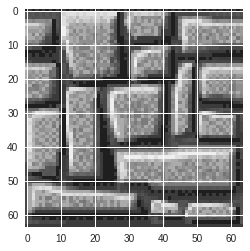

In [64]:
from skimage import io
import matplotlib.pyplot as plt

image = io.imread("https://raw.githubusercontent.com/lsmanoel/raycasting/master/wolftex/pics/greystone.png")

plt.imshow(image)
plt.show()

# Raycaster - Código

Como dito anteriormente, o mapa é uma matriz de duas dimensões onde o valor zero representa espacos onde não há paredes e o valores diferentes de zero podem representar paredes de diferentes cores e texturas.

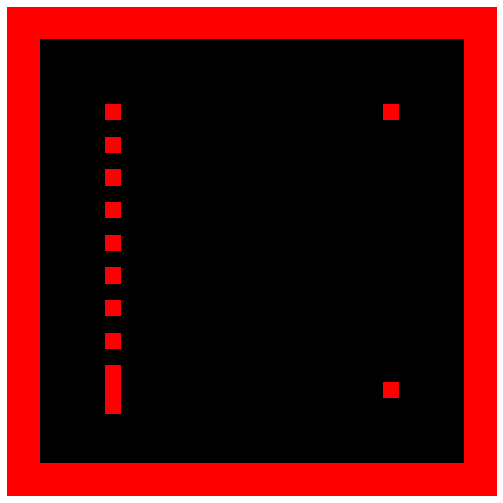

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [34]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
% matplotlib inline


wall_map = np.zeros((30, 30), dtype=int)
wall_map[:, :2]=1
wall_map[:2, :]=1
wall_map[:, -2:]=1
wall_map[-2:, :]=1

wall_map[6:7, 6:7]=1
wall_map[8:9, 6:7]=1
wall_map[10:11, 6:7]=1
wall_map[12:13, 6:7]=1
wall_map[14:15, 6:7]=1
wall_map[16:17, 6:7]=1
wall_map[18:19, 6:7]=1
wall_map[20:21, 6:7]=1
wall_map[22:23, 6:7]=1
wall_map[24:25, 6:7]=1


wall_map[6:7, -7:-6]=1

wall_map[-7:-6, -7:-6]=1

wall_map[-7:-6, 6:7]=1

cmap = mpl.colors.ListedColormap(['black','blue','red'])
plt.figure(figsize=(9,9))
plt.imshow(wall_map, cmap=cmap)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

print(wall_map)


In [0]:
from skimage import io
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
% matplotlib inline

class observer:
  def __init__(self,
               surface_map,
               screen_size=None,
               position=None,
               direction=None,
               cam_plane=None,
               texture_mode=True):
    
    self.surface_map = surface_map
    
    if screen_size == None:
      self.screen_size = [340, 480, 3]
    else:
      self.screen_size = screen_size
    
    self.screen = np.zeros(self.screen_size, dtype=int)
    
    if position == None:
      self.position = [shape//2 for shape in surface_map.shape]
    else:
      self.position = position
      
    if direction == None:
      self.direction = [-1, 0]
    else:
      self.direction = direction
      
    if cam_plane == None:
      self.cam_plane = [0, 0.66]# ângulo de abertura: 2*atan(0.66/1.0)=66°
    else: 
      self.cam_plane = cam_plane
    
    self.texture_mode = texture_mode
    if texture_mode is True:
      self.texture_map = io.imread("https://raw.githubusercontent.com/lsmanoel/raycasting/master/wolftex/pics/greystone.png")
      self.texture_size = self.texture_map.shape
      self.texture_map=self.texture_map.reshape(self.texture_size[0]*self.texture_size[1], 3)
    
    self._camera = [0, 0]
    self._ray_pos = [0, 0]
    self._ray_dir = [0, 0]
    self._sideDist = [0, 0]
    self._deltaDist = [0, 0]
    self._perpWallDist = 1
    self._step = [0, 0]
    self._hit = False
    self._side = False
    self._lineHeight = 0
    self._drawStart = 0
    self._drawEnd = 0

  def plot_screen(self):
    plt.figure(figsize=(9,9))
    plt.imshow(self.screen)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

  def draw_line(self, x):
    if self._side is True:
      self.screen[self._drawStart:self._drawEnd, x, 0] = 255
    else:
      self.screen[self._drawStart:self._drawEnd, x, 0] = 128
      
  def draw_texture(self, x):
    # Texturing calculations
    texture_id = self.surface_map[self._ray_pos[0], self._ray_pos[1]]
    
    # Calculate value of wallX
    if self._side is False:
      wall_x = self.position[1] + self._perpWallDist*self._ray_dir[1]
    else:
      wall_x = self.position[0] + self._perpWallDist*self._ray_dir[0]
    
    wall_x -= math.floor((wall_x))
    
    # X coordinate on the texture
    texture_x = int(wall_x * self.texture_size[0])
    if self._side is False and self._ray_dir[0] > 0:
      texture_x = self.texture_size[0] - texture_x -1
    if self._side is True and self._ray_dir[1] < 0:
      texture_x = self.texture_size[0] - texture_x -1
      
    for y in range(self._drawStart, self._drawEnd):
      d = y*256 - self.screen_size[0]*128 + self._lineHeight*128
      texture_y = ((d*self.texture_size[1])/self._lineHeight)//256
      
      color = self.texture_map[int(self.texture_size[1]*texture_y + texture_x),:]
      if self._side is True:
        color = [c//2 for c in color]
      self.screen[y, x, :] = color  
    
  def update_raycasting(self):
    self.screen = np.zeros(self.screen_size, dtype=int)
    for x in range(self.screen_size[1]):
      # ------------------------------------------------------------------------
      # Calculate ray position and direction
      self._camera[0] = 2*x/self.screen_size[1] - 1
      
      self._ray_dir[0] = self.direction[0]+self.cam_plane[0]*self._camera[0]
      if self._ray_dir[0] == 0:
        self._ray_dir[0] += 0.00001
      self._ray_dir[1] = self.direction[1]+self.cam_plane[1]*self._camera[0]
      if self._ray_dir[1] == 0:
        self._ray_dir[1] += 0.00001
        
      self._deltaDist = [abs(1/ray_dir) for ray_dir in self._ray_dir]
      self._ray_pos = [pos for pos in self.position]
      
      for i, ray_dir in enumerate(self._ray_dir):
        if ray_dir < 0:
            self._step[i] = -1
            self._sideDist[i] = (self.position[i]-self._ray_pos[i])*self._deltaDist[i]
        else:
            self._step[i] = 1
            self._sideDist[i] = (self._ray_pos[i]+1.0-self.position[i])*self._deltaDist[i]
      
      # ------------------------------------------------------------------------
      # Perform DDA
      self._hit = False
      while self._hit is False:
        # Jump to next map square, or in x-dir, or y-dir
        if self._sideDist[0] < self._sideDist[1]:
          self._sideDist[0] += self._deltaDist[0]
          self._ray_pos[0] += self._step[0]
          self._side = False
        else:
          self._sideDist[1] += self._deltaDist[1]
          self._ray_pos[1] += self._step[1]
          self._side = True

        # Check if ray has hit a wall
        if self.surface_map[self._ray_pos[0], self._ray_pos[1]] > 0: 
          self._hit = True
          
      # ------------------------------------------------------------------------    
      # Calculate distance projected on camera direction 
      # (Euclidean distance will give fisheye effect!)
      if self._side is False: 
        self._perpWallDist = (self._ray_pos[0]-self.position[0]+(1-self._step[0])/2)/self._ray_dir[0]
      else:
        self._perpWallDist = (self._ray_pos[1]-self.position[1]+(1-self._step[1])/2)/self._ray_dir[1]
  
      # ------------------------------------------------------------------------
      # Calculate height of line to draw on screen
      self._lineHeight = 2*self.screen_size[0] /self._perpWallDist

      # ------------------------------------------------------------------------
      # Calculate lowest and highest pixel to fill in current stripe
      self._drawStart = int(-self._lineHeight//2 + self.screen_size[0]//2)
      if self._drawStart < 0:
        self._drawStart = 0

      self._drawEnd = int(self._lineHeight//2+self.screen_size[0]//2)
      if self._drawEnd >= self.screen_size[0]:
        self._drawEnd = int(self.screen_size[0] - 1)
      
      if self.texture_mode is True:  
        self.draw_texture(x)
      else:
        self.draw_line(x)
  
  def forward(self, speed):
    if self.surface_map[int(self.position[0] + self.direction[0]), int(self.position[1])] == 0:
      self.position[0] += int(speed*self.direction[0])
    if self.surface_map[int(self.position[0]), int(self.position[1] + self.direction[1])] == 0:
      self.position[1] += int(speed*self.direction[1])
      
  @property
  def position(self):
    return self._position
  
  @position.setter
  def position(self, value):
    if value is not None:
      self._position = [int(i) for i in value]

  @property
  def theta(self):
    return self._theta

  @theta.setter
  def theta(self, value):
    self._theta = value
    new_dirX = self.direction[0]*np.cos(self._theta) - self.direction[1]*np.sin(self._theta)
    new_dirY = self.direction[0]*np.sin(self._theta) + self.direction[1]*np.cos(self._theta)
    self.direction = [new_dirX, new_dirY]
    new_cam_planeX = self.cam_plane[0]*np.cos(self._theta) - self.cam_plane[1]*np.sin(self._theta)
    new_cam_planeY = self.cam_plane[0]*np.sin(self._theta) + self.cam_plane[1]*np.cos(self._theta)
    self.cam_plane = [new_cam_planeX, new_cam_planeY]
    

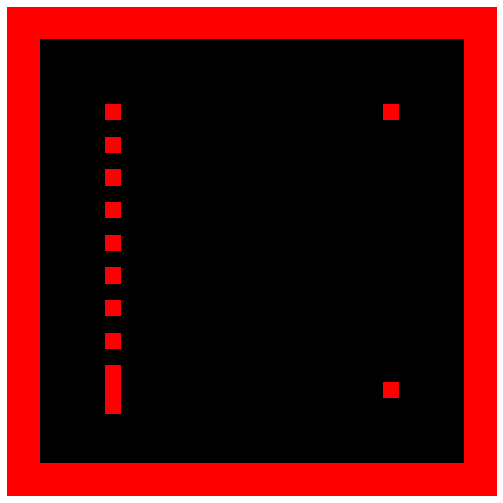

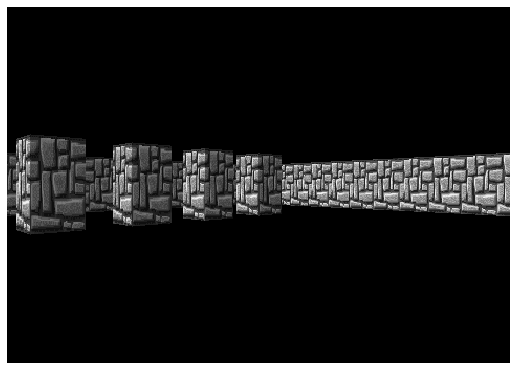

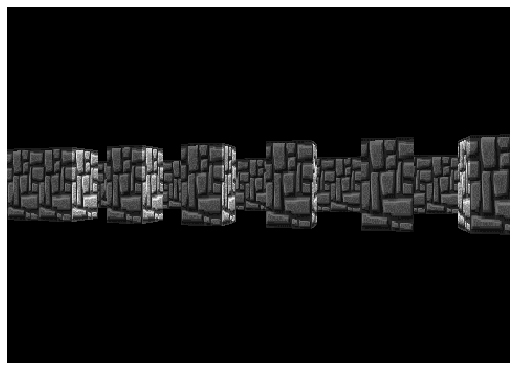

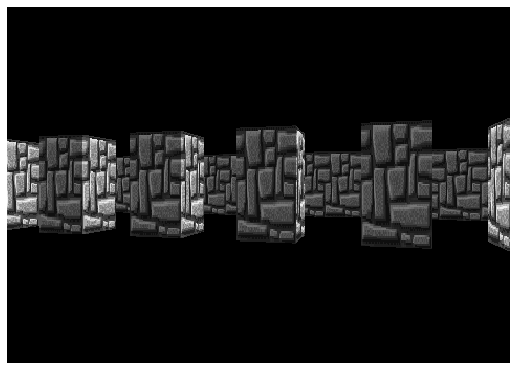

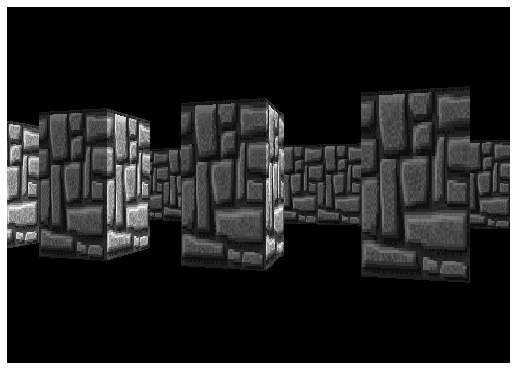

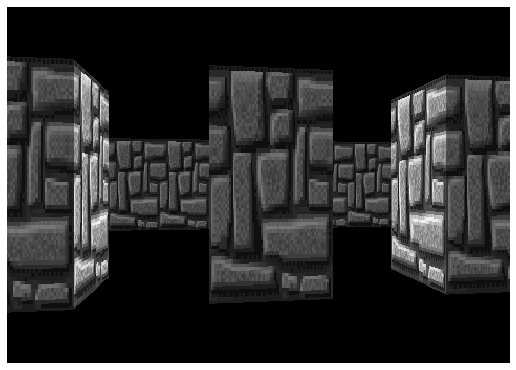

In [66]:
wall_map = np.zeros((30, 30), dtype=int)
wall_map[:, :2]=1
wall_map[:2, :]=1
wall_map[:, -2:]=1
wall_map[-2:, :]=1

wall_map[6:7, 6:7]=1
wall_map[8:9, 6:7]=1
wall_map[10:11, 6:7]=1
wall_map[12:13, 6:7]=1
wall_map[14:15, 6:7]=1
wall_map[16:17, 6:7]=1
wall_map[18:19, 6:7]=1
wall_map[20:21, 6:7]=1
wall_map[22:23, 6:7]=1
wall_map[24:25, 6:7]=1


wall_map[6:7, -7:-6]=1

wall_map[-7:-6, -7:-6]=1

wall_map[-7:-6, 6:7]=1

cmap = mpl.colors.ListedColormap(['black','blue','red'])
plt.figure(figsize=(9,9))
plt.imshow(wall_map, cmap=cmap)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show

obs_1 = observer(wall_map, texture_mode=True)

obs_1.theta = np.pi/4
obs_1.update_raycasting()
obs_1.plot_screen()

obs_1.theta = np.pi/3
obs_1.update_raycasting()
obs_1.plot_screen()

obs_1.forward(3)
obs_1.update_raycasting()
obs_1.plot_screen()

obs_1.forward(3)
obs_1.update_raycasting()
obs_1.plot_screen()

obs_1.forward(2)
obs_1.theta = np.pi/-8
obs_1.update_raycasting()
obs_1.plot_screen()